# Phys 581 Winter 2019
# Assignment #3: Data fitting
## Alexander Hickey, 10169582

In [2]:
#Import useful libraries
import numpy as np
import scipy.stats
import scipy.optimize
import matplotlib.pyplot as plt
%matplotlib inline

### Introduction

Type stuff...

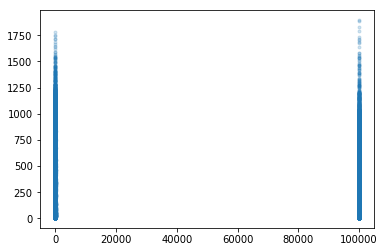

dtype([('year', '<i4'), ('day', '<i4'), ('hour', '<i4'), ('minute', '<i4'), ('imf_id', '<i4'), ('plasma_id', '<i4'), ('imf_n_average', '<i4'), ('plasma_n_average', '<i4'), ('percent_interpolated', '<i4'), ('timeshift', '<i4'), ('timeshift_rms', '<i4'), ('pfn_rms', '<f4'), ('observation_time_delta', '<i4'), ('b_magnitude', '<f4'), ('bx', '<f4'), ('by', '<f4'), ('bz', '<f4'), ('by_gsm', '<f4'), ('bz_gsm', '<f4'), ('b_magnitude_rms', '<f4'), ('b_vector_rms', '<f4'), ('v', '<f4'), ('vx', '<f4'), ('vy', '<f4'), ('vz', '<f4'), ('proton_density', '<f4'), ('temperature', '<f4'), ('dynamic_pressure', '<f4'), ('electric_field', '<f4'), ('plasma_beta', '<f4'), ('alfven_mach_number', '<f4'), ('pos_x', '<f4'), ('pos_y', '<f4'), ('pos_z', '<f4'), ('bow_x', '<f4'), ('bow_y', '<f4'), ('bow_z', '<f4'), ('ae_index', '<i4'), ('al_index', '<i4'), ('au_index', '<i4'), ('symd_index', '<i4'), ('symh_index', '<i4'), ('asymd_index', '<i4'), ('asymh_index', '<i4'), ('pc_index', '<f4'), ('magnetosonic_mach_numbe

In [3]:
#Data doesn't make sense
data = np.load('omni_1min_2014.npy')
plt.plot( data['vz'], data['ae_index'], '.', alpha=0.2 )
plt.show()
data.dtype

Browsing through the documentation of the data, we see that the records corresponding to missed data are set to 9999. 

In [4]:
# Standardize variables to reduce numerical instability
dtype = np.dtype([ ('min', np.double), ('max', np.double), ('mean', np.double), ('stdev', np.double)])

process = {}
process['bz'] = np.array([(-29, +29, np.nan, np.nan)], dtype=dtype)
process['bx'],process['by'] = process['bz'].copy(), process['bz'].copy()

process['vx'] = np.array([(-2100, +50.0, np.nan, np.nan)], dtype=dtype) 
process['vy'],process['vz'] = process['vx'].copy(), process['vx'].copy()

process['ae_index'] = np.array([(-100, +2999, np.nan, np.nan)], dtype=dtype) 

In [5]:
alltrue = np.ones( len(data), dtype=np.bool )

for name in process:
    p = process[name]
    wgood = (data[name] >= p['min']) & (data[name] <= p['max'])
    alltrue = alltrue & wgood   


newdat = {}
for name in process:
    p = process[name]
    dat = data[name][alltrue].astype(np.double)
    
    #Shift data to mean and rescale by standard deviation
    p['mean'] = np.mean( dat )
    p['stdev'] = np.std( dat )
    dat = ( dat - p['mean'] ) / p['stdev']
    
    newdat[name] = dat

In [9]:
#We want to fit the 'ae_index' data using the other variables
if 'ae_index' in newdat:
    
    AE = newdat.pop('ae_index')
    xfit = newdat.copy()

Plotting the standardized data shows that the data is grouped togethor and of order 1.

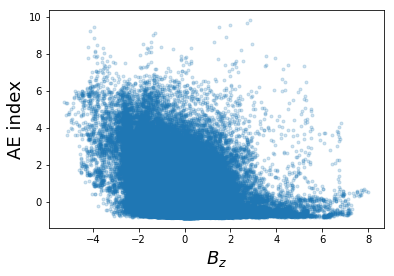

In [10]:
plt.plot( xfit['bz'], AE,'.', alpha=.2)
plt.xlabel('$B_z$',fontsize=18)
plt.ylabel('AE index',fontsize=18)
plt.show()

##### Task:

Use tools in scipy.optimize (or elsewhere) to fit a linear model with a single variable 

 $$ AE = c_1 B_z $$

by finding the value of $c_1$ which minimizes the goodness of fit given by 

 $$ \chi^2 = \sum (\mathrm{model} - \mathrm{data})^2 $$

then try two variables

 $$ AE = c_1 B_z + c_2 v_x $$
 
then try a non-linear transformation of a single variable
 
 $$ AE = c_1 B_z + c_2 v_x^2 $$ 
 
then try cross terms 

 $$ AE = c_1 B_z + c_2 v_x + c_3 B_z v_x $$ 
 
then explore combinations and transformations of variables to obtain "the best" model.  Think about what that means.

In [13]:
def chi2(param, x, y, model):
    ''' 
    Computes the deviation of a model from a data set, rescaled by
    the length of the data set. This function will be called by an
    optimizer to determine the 'best fit' parameters of a given model.
    
    Args:
        param: array, parameters to use for the model
        x: dict, contains arrays of values used to fit the data
        y: array of data to be fit
        model: function, defines which model to fit the data with
        
    Return:
        chi2: Normalized chi-squared value of the model.
    '''
    
    dy = y - model(param, x)
    
    return np.sum(dy**2) / len(y)

def model_1(param, x):
    '''
    Linear, single coefficient model: y = c0*bz
    
    Args:
        param: array, parameters to use for the model
        x: dict, contains arrays of values used to fit the data
        
    Return:
        y: Data predicted by the model for a given set of coefficients.
    '''
    y =  x['bz'] * param[0]
    
    return y

def model_2(param, x):
    '''
    Linear, two coefficient model: y = c0*bz + c1
    
    Args:
        param: array, parameters to use for the model
        x: dict, contains arrays of values used to fit the data
        
    Return:
        y: Data predicted by the model for a given set of coefficients.
    '''
    y = param[0] + x['bz'] * param[1]
    
    return y


def model_3(param, x):
    '''
    Two-variable model: y = c0 + c1*bz + c2*vx
    
    Args:
        param: array, parameters to use for the model
        x: dict, contains arrays of values used to fit the data
        
    Return:
        y: Data predicted by the model for a given set of coefficients.
    '''
    y = param[0] + param[1]*x['bz'] + param[2] * x['vx']
    
    return y


def model_4(param, x):
    '''
    Two-variable quadratic model: y = c0 + c1*bz + c2*vx^2
    
    Args:
        param: array, parameters to use for the model
        x: dict, contains arrays of values used to fit the data
        
    Return:
        y: Data predicted by the model for a given set of coefficients.
    '''
    y = param[0] + param[1]*x['bz'] + param[2] * x['vx']*x['vx']
    
    return y

def model_5(param, x):
    '''
    Two-variable cross-term model: y = c0 + c1*bz + c2*vx + c3*bz*vx
    
    Args:
        param: array, parameters to use for the model
        x: dict, contains arrays of values used to fit the data
        
    Return:
        y: Data predicted by the model for a given set of coefficients.
    '''
    y = param[0] + param[1]*x['bz']+ param[2]*x['vx'] + param[3]*x['bz']*x['vx']
    
    return y

In [31]:
guess = np.ones(4)

res1 = scipy.optimize.minimize(chi2, guess[:1], (xfit, AE,model_1) )
res2 = scipy.optimize.minimize(chi2, guess[:2], (xfit, AE,model_2) )
res3 = scipy.optimize.minimize(chi2, guess[:3], (xfit, AE,model_3) )
res4 = scipy.optimize.minimize(chi2, guess[:3], (xfit, AE,model_4) )
res5 = scipy.optimize.minimize(chi2, guess[:4], (xfit, AE,model_5) )
print(res1['fun'],res2['fun'],res3['fun'],res4['fun'],res5['fun'])

0.854620759404654 0.8546207594046816 0.8062733265093639 0.8372662878198709 0.8049258474512966


Next try a more complicated model.

In [37]:
def complicated_model():
    '''
    
    '''
    
    return 1.0

### Conclusion

In conclusion...